In [2]:
import numpy as np
import COMSTABPY as csb
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
#load the stability analysis module
stb = csb.comstab()

In [4]:
#load the data
ncname = 'result_deep_summer.nc'
ds = xr.open_dataset(ncname)
time = np.array(ds['time'][:])
depth = np.array(ds['depth'][:])

In [5]:
#communities names: phytoplankton, zooplankton, total(B+P+Z)
communities = ['P','Z','TOT']

In [6]:
#create arrays where to save results
#we will save the mean along the depth axis and the standard deviation
cvs_arr = np.zeros((len(communities),len(depth),4)) #CV_e,CV_tilde,CV_a,CV_c
stb_arr = np.zeros((len(communities),len(depth),4)) #tau,Delta,psi,omega
rel_arr = np.zeros((len(communities),len(depth),3)) #relative Delta,psi,omega

In [7]:
%%capture  
#suppress the output of the loop, to avoid printing warning messages from the stability analysis
#loop over the communities and perform the stability analysis
for icomm,community in enumerate(communities):
    data = np.array(ds[community])[:,:,:]
    #loop over the depth
    for idepth in range(data.shape[2]):
        try:
            #remove rows with all nan values of temporal axis of data
            mask = np.isnan(data[:,:,idepth]).all(axis=1)
            result = stb.partition(data[~mask,:,idepth],stamp=False)
            cvs_arr[icomm,idepth] = result['CVs']
            stb_arr[icomm,idepth] = result['Stabilization']
            rel_arr[icomm,idepth] = result['Relative']
        except:
            cvs_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan,np.nan])
            stb_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan,np.nan])
            rel_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan])
            continue
    

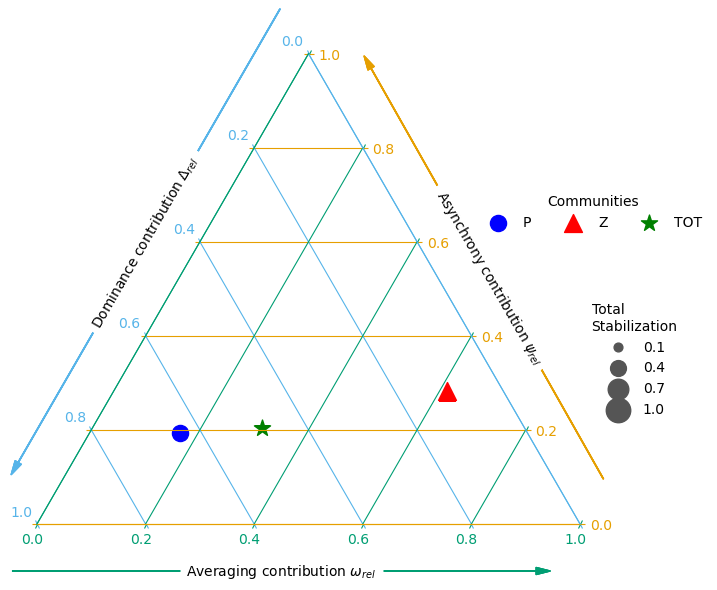

In [8]:
#Ternary plot
#please use numpy arrays for markers, labels and colors
markers = np.array(['o','^','*']) #use a different marker for each community
labels = np.array(['P','Z','TOT']) #label the communities
colors = np.array(['blue','red','green']) #use a different color for each community

stb_mean = np.nanmean(stb_arr,axis=1)
arr_tau = stb_mean[:,0]

rel_mean = np.nanmean(rel_arr,axis=1)
rel_std = np.nanstd(rel_arr,axis=1)

fig,ax = stb.ternaryplot(res=rel_mean,tau=arr_tau,sizelegend=True,marker=markers,labels=labels,color=colors,figname='ternary.png')


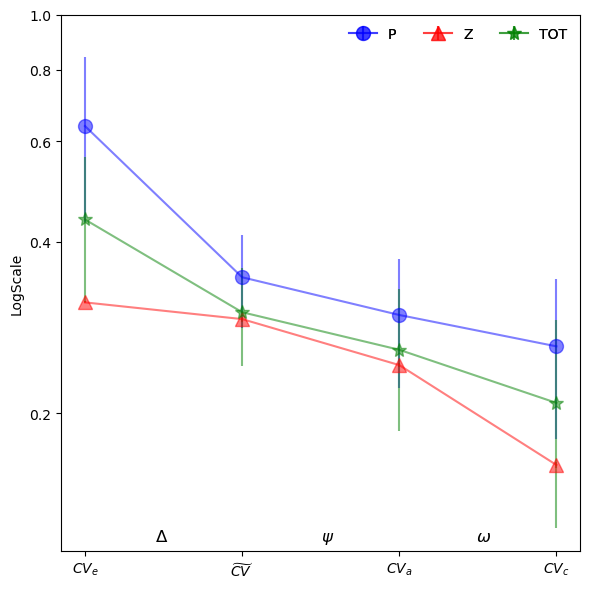

In [9]:
#Plot the CVs using the standard deviation as errorbars
cvs_mean = np.nanmean(cvs_arr,axis=1)
cvs_std = np.nanstd(cvs_arr,axis=1)
fig,ax = stb.plotCV(CV_arr=cvs_mean,ylabel='LogScale',errorbar=cvs_std,marker=markers,labels=labels,color=colors,figname='CVs.png')



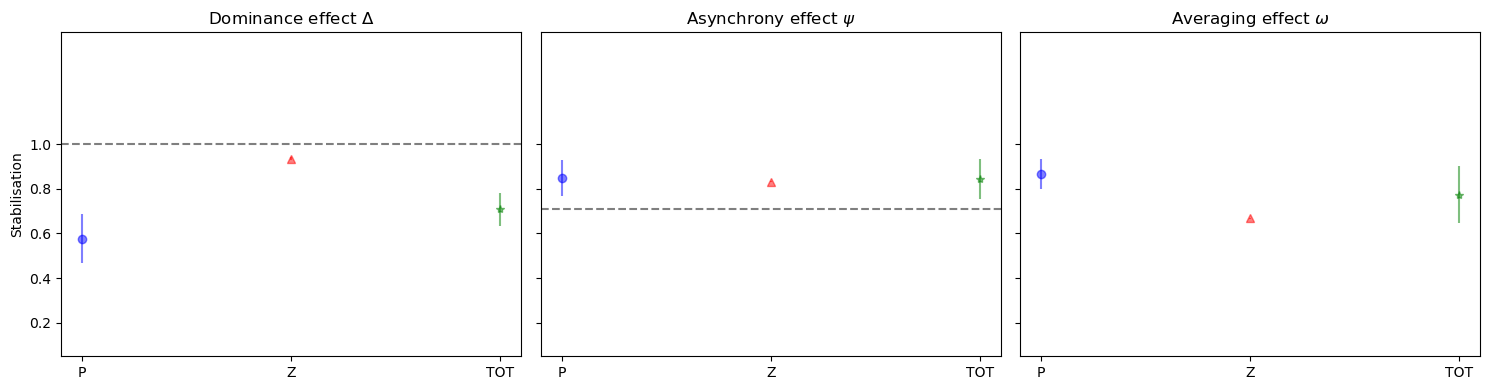

In [10]:
#Plot the stabilzing effects using the standard deviation as errorbars
effects = stb_mean[:,1:] #Delta,psi,omega
stb_std = np.nanstd(stb_arr,axis=1)
errors = stb_std[:,1:]   #Delta,psi,omega
fig,ax = stb.plotEFFECT(EFF=effects,ylogscale=False,errorbar=errors,marker=markers,labels=labels,color=colors,figname='effect.png')


In [11]:
#Perform Tukey's test
#on Delta, comparing the three communities, using the depth as samples
tukey_std = stb.Tukey(stb_arr[:,:,1], labels=labels, savecsv=True, csvname='std_Tukey.csv')
#show the p-values
tukey_std 

,P,Z,TOT
P,1.000000,0.000014,0.000033
Z,0.000014,1.000000,0.005699
TOT,0.000033,0.005699,1.000000
